In [12]:
# 1. 导入必要的库和设置
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models.vae import TemporalVAE
from utils.data_loader import DengueDataset
from config import Config
import pandas as pd
from datetime import datetime

In [13]:
# 2. 加载数据和模型
class ModelLoader:
    def __init__(self, model_path="checkpoints/best_models/best_model.pth"):
        self.config = Config()
        self.device = self.config.DEVICE
        
        # 加载数据
        self.dataset = DengueDataset(self.config)
        self.district_labels = np.load('Data/vae_district_labels.npy', allow_pickle=True)
        self.time_labels = np.load('Data/vae_time_labels.npy', allow_pickle=True)
        
        # 加载特征名称
        with open('Data/vae_feature_names.txt', 'r') as f:
            self.feature_names = f.read().splitlines()
        
        # 初始化模型
        input_dim = self.dataset.data.shape[-1]
        self.model = TemporalVAE(
            input_dim=input_dim,
            hidden_dim=self.config.HIDDEN_DIM,
            latent_dim=self.config.LATENT_DIM,
            time_window=self.config.TIME_WINDOW
        ).to(self.device)
        
        # 加载模型权重
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

# 初始化模型加载器
model_loader = ModelLoader(model_path="checkpoints/best_models/best_model.pth")
print("模型加载完成")
print(f"数据集大小: {len(model_loader.dataset)}")
print(f"特征维度: {model_loader.feature_names}")

Loaded data shape: torch.Size([595, 6, 6])


E:\Program\Anaconda\envs\LandVAE\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\17164\AppData\Local\Temp\ipykernel_21572\56176106.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

模型加载完成
数据集大小: 595
特征维度: ['AGI', 'ADI', 'POPN_D', 'LA', 'month', 'season_num']


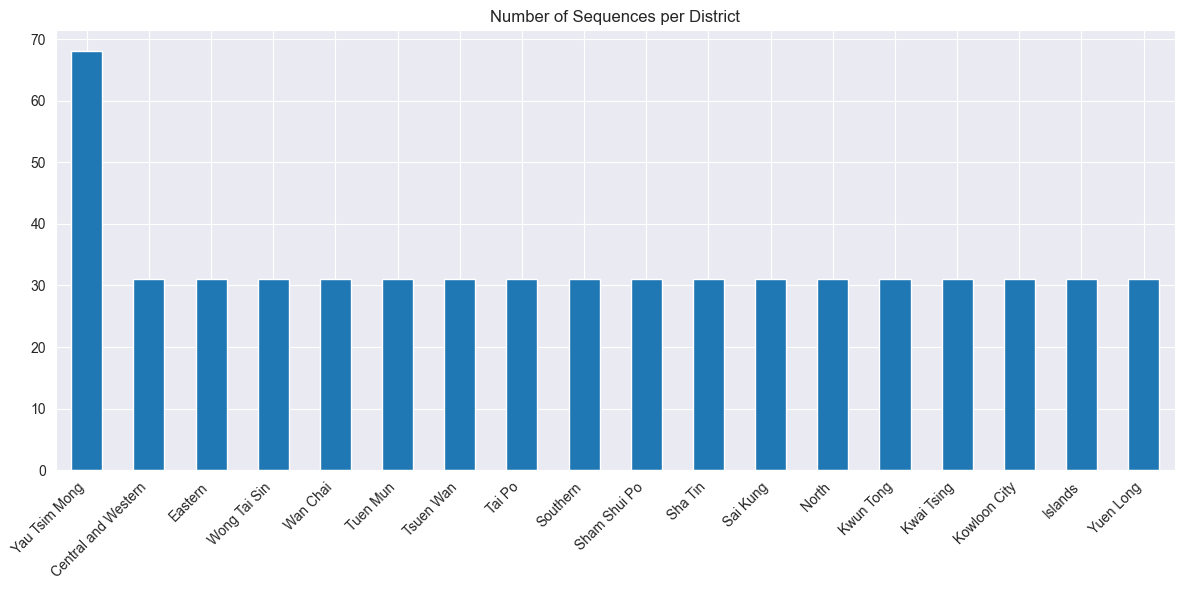

In [14]:
# 3. 查看数据分布
# 显示不同地区的数据分布
district_counts = pd.Series(model_loader.district_labels).value_counts()

plt.figure(figsize=(12, 6))
district_counts.plot(kind='bar')
plt.title('Number of Sequences per District')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

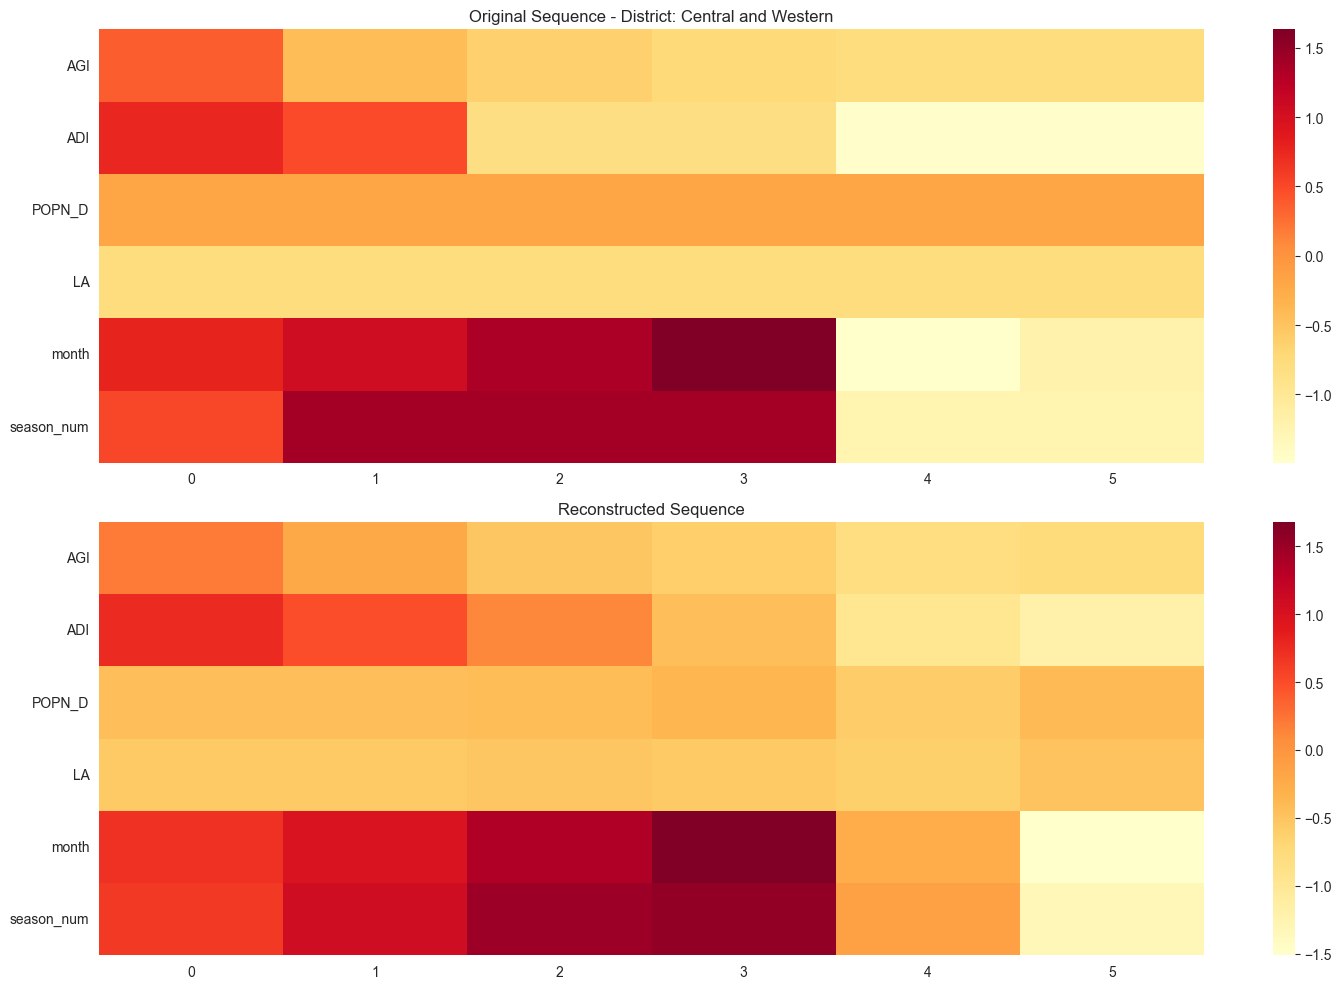

In [15]:
# 4. 时间序列可视化
def plot_sequence(idx):
    """可视化单个时间序列"""
    with torch.no_grad():
        data = model_loader.dataset[idx].unsqueeze(0).to(model_loader.device)
        recon, mu, log_var = model_loader.model(data)
        
    original = data.cpu().numpy()[0]
    reconstruction = recon.cpu().numpy()[0]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # 原始序列
    sns.heatmap(original.T, ax=ax1, 
                xticklabels=range(model_loader.config.TIME_WINDOW),
                yticklabels=model_loader.feature_names,
                cmap='YlOrRd')
    ax1.set_title(f'Original Sequence - District: {model_loader.district_labels[idx]}')
    
    # 重建序列
    sns.heatmap(reconstruction.T, ax=ax2,
                xticklabels=range(model_loader.config.TIME_WINDOW),
                yticklabels=model_loader.feature_names,
                cmap='YlOrRd')
    ax2.set_title('Reconstructed Sequence')
    
    plt.tight_layout()
    plt.show()
    
    return original, reconstruction

# 查看第一个序列
original, reconstruction = plot_sequence(0)

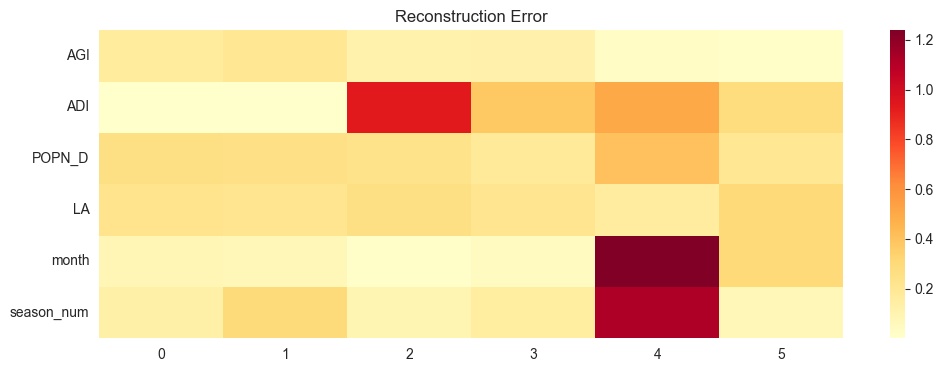


平均重建误差:


,Feature,Mean Error
1,ADI,0.348354
5,season_num,0.311632
4,month,0.293396
2,POPN_D,0.255956
3,LA,0.231837
0,AGI,0.106577


In [16]:
# 5. 重建误差分析
def analyze_reconstruction_error(original, reconstruction):
    error = np.abs(original - reconstruction)
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(error.T, 
                xticklabels=range(model_loader.config.TIME_WINDOW),
                yticklabels=model_loader.feature_names,
                cmap='YlOrRd')
    plt.title('Reconstruction Error')
    plt.show()
    
    # 打印每个特征的平均误差
    mean_error = error.mean(axis=0)
    error_df = pd.DataFrame({
        'Feature': model_loader.feature_names,
        'Mean Error': mean_error
    })
    return error_df.sort_values('Mean Error', ascending=False)

error_df = analyze_reconstruction_error(original, reconstruction)
print("\n平均重建误差:")
display(error_df)

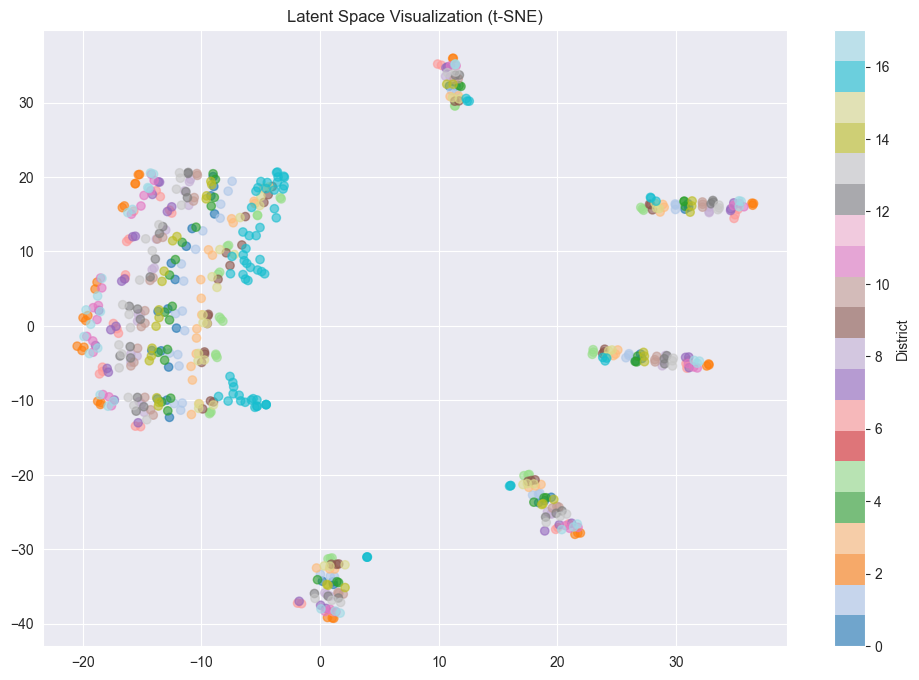

In [17]:
# 6. 潜在空间可视化
def visualize_latent_space(n_samples=1000):
    encoded_data = []
    districts = []
    
    with torch.no_grad():
        for i in range(min(n_samples, len(model_loader.dataset))):
            data = model_loader.dataset[i].unsqueeze(0).to(model_loader.device)
            mu, _ = model_loader.model.encoder(data)
            encoded_data.append(mu.cpu().numpy())
            districts.append(model_loader.district_labels[i])
    
    encoded_data = np.vstack(encoded_data)
    
    # t-SNE降维
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    encoded_2d = tsne.fit_transform(encoded_data)
    
    # 可视化
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], 
                         c=pd.Categorical(districts).codes, 
                         cmap='tab20', alpha=0.6)
    plt.title('Latent Space Visualization (t-SNE)')
    plt.colorbar(scatter, label='District')
    plt.show()

visualize_latent_space()

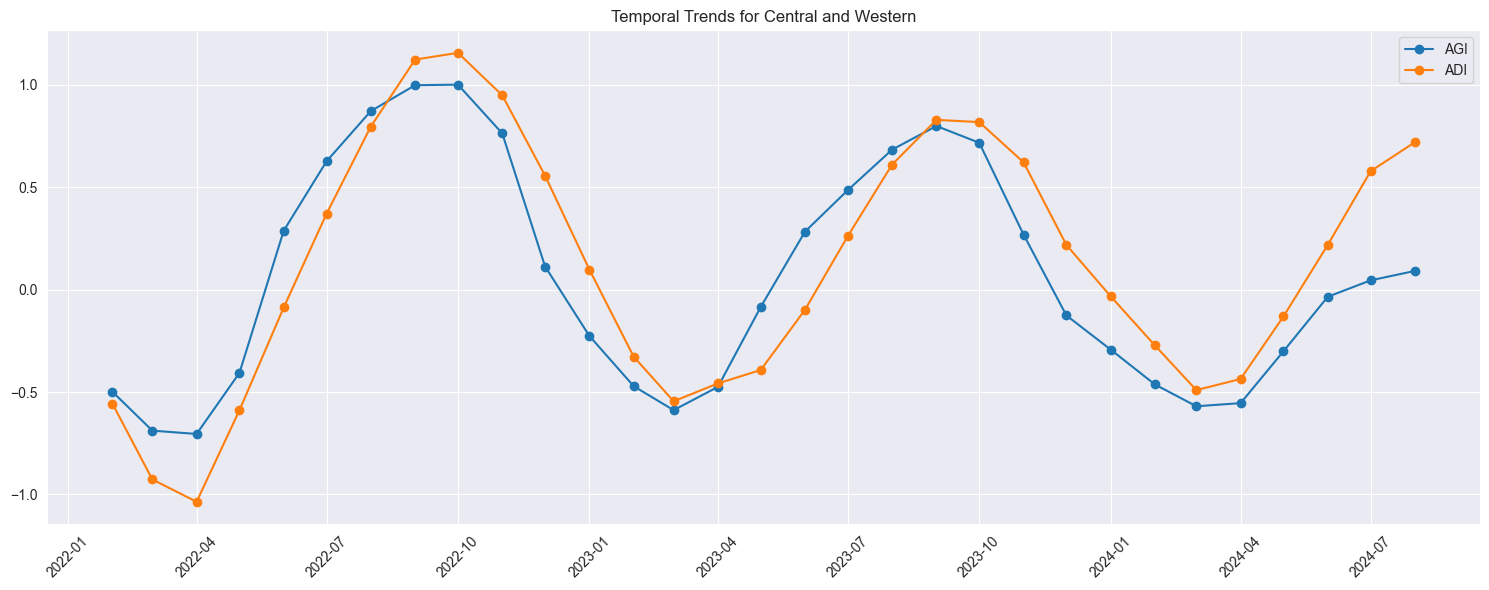

In [18]:
# 7. 时间趋势分析
def analyze_temporal_trends(district_name):
    district_indices = np.where(model_loader.district_labels == district_name)[0]
    
    if len(district_indices) == 0:
        print(f"No data found for district: {district_name}")
        return
    
    # 收集该地区的AGI和ADI值
    times = []
    agi_values = []
    adi_values = []
    
    for idx in district_indices:
        data = model_loader.dataset[idx].numpy()
        times.append(model_loader.time_labels[idx])
        # 假设AGI和ADI是前两个特征
        agi_values.append(data[:, 0].mean())  # 取平均值
        adi_values.append(data[:, 1].mean())
    
    # 创建时间序列图
    plt.figure(figsize=(15, 6))
    plt.plot(times, agi_values, label='AGI', marker='o')
    plt.plot(times, adi_values, label='ADI', marker='o')
    plt.title(f'Temporal Trends for {district_name}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 分析特定地区的时间趋势
analyze_temporal_trends("Central and Western")

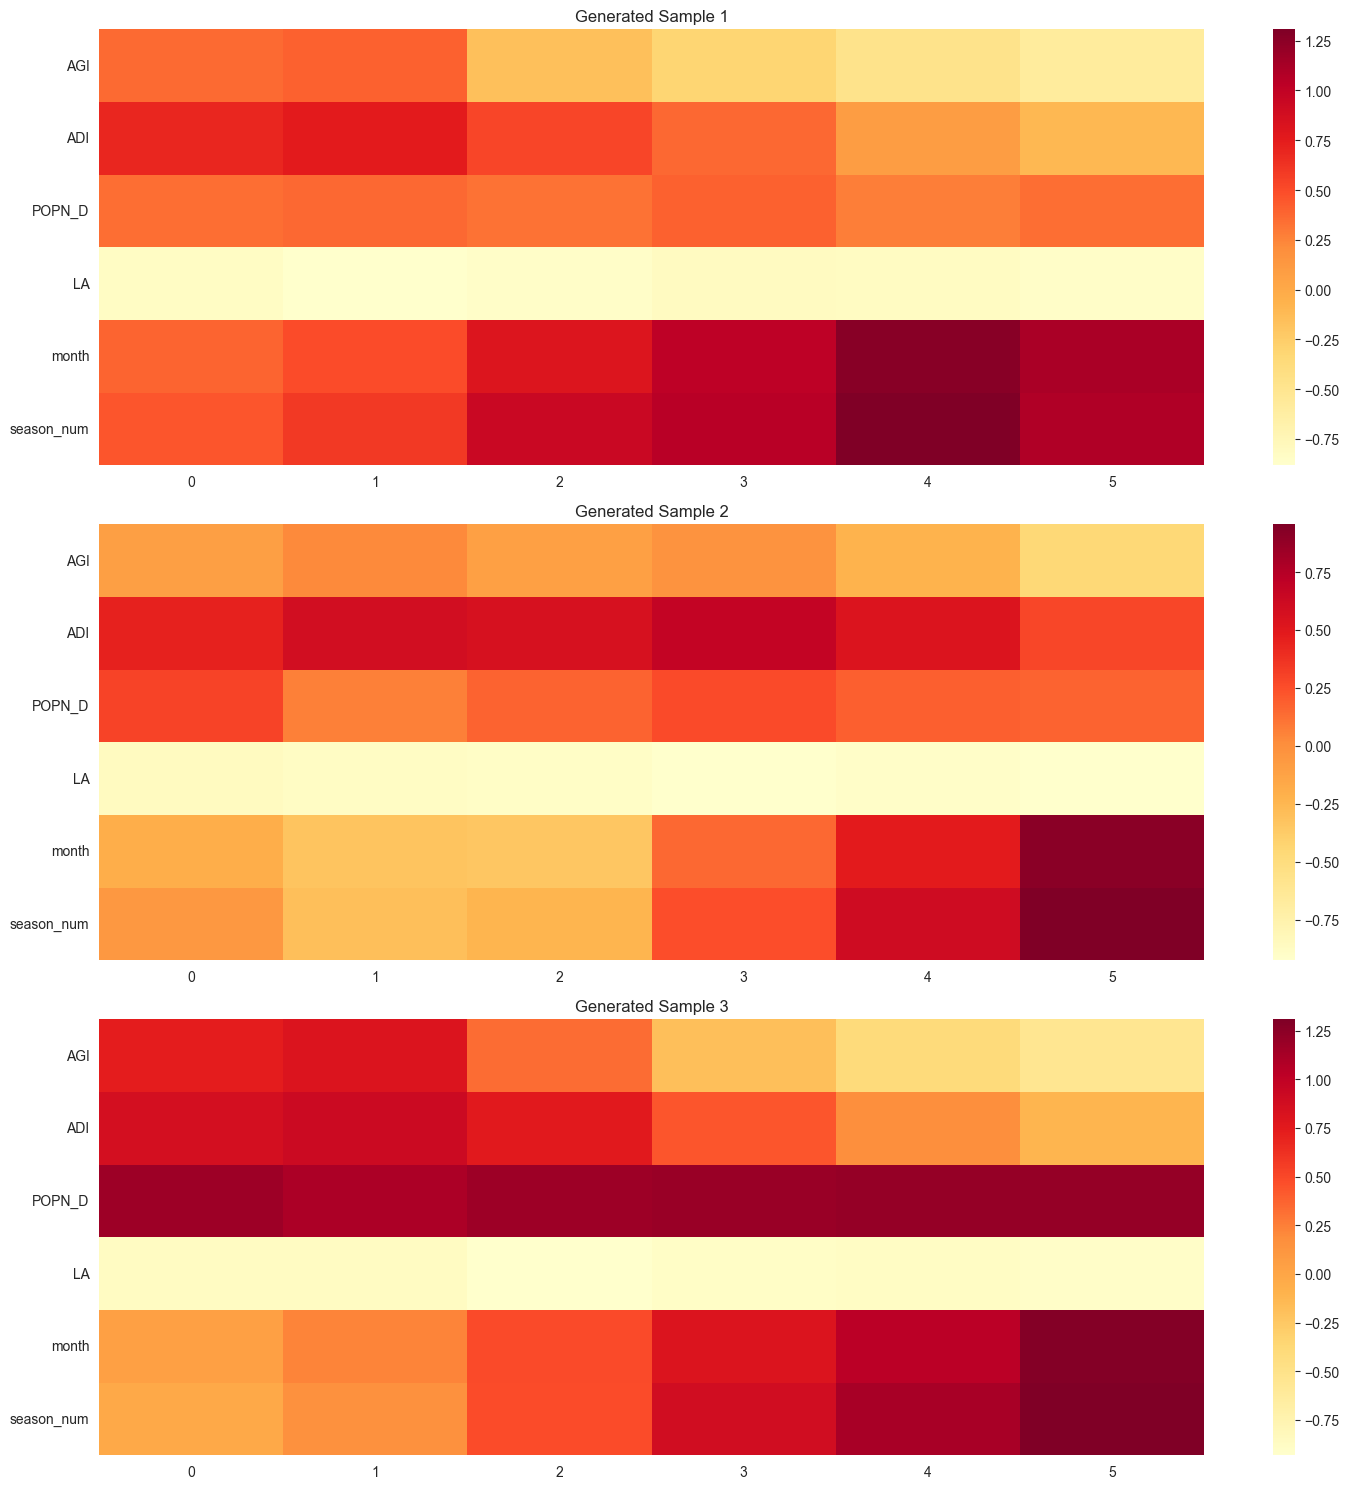

In [19]:
# 8. 生成新样本
def generate_and_visualize_samples(n_samples=3):
    with torch.no_grad():
        # 从正态分布采样潜在向量
        z = torch.randn(n_samples, model_loader.config.LATENT_DIM).to(model_loader.device)
        # 生成新样本
        generated = model_loader.model.decoder(z)
        generated = generated.cpu().numpy()
    
    # 可视化生成的样本
    fig, axes = plt.subplots(n_samples, 1, figsize=(15, 5*n_samples))
    for i in range(n_samples):
        sns.heatmap(generated[i].T, ax=axes[i],
                   xticklabels=range(model_loader.config.TIME_WINDOW),
                   yticklabels=model_loader.feature_names,
                   cmap='YlOrRd')
        axes[i].set_title(f'Generated Sample {i+1}')
    
    plt.tight_layout()
    plt.show()

generate_and_visualize_samples()

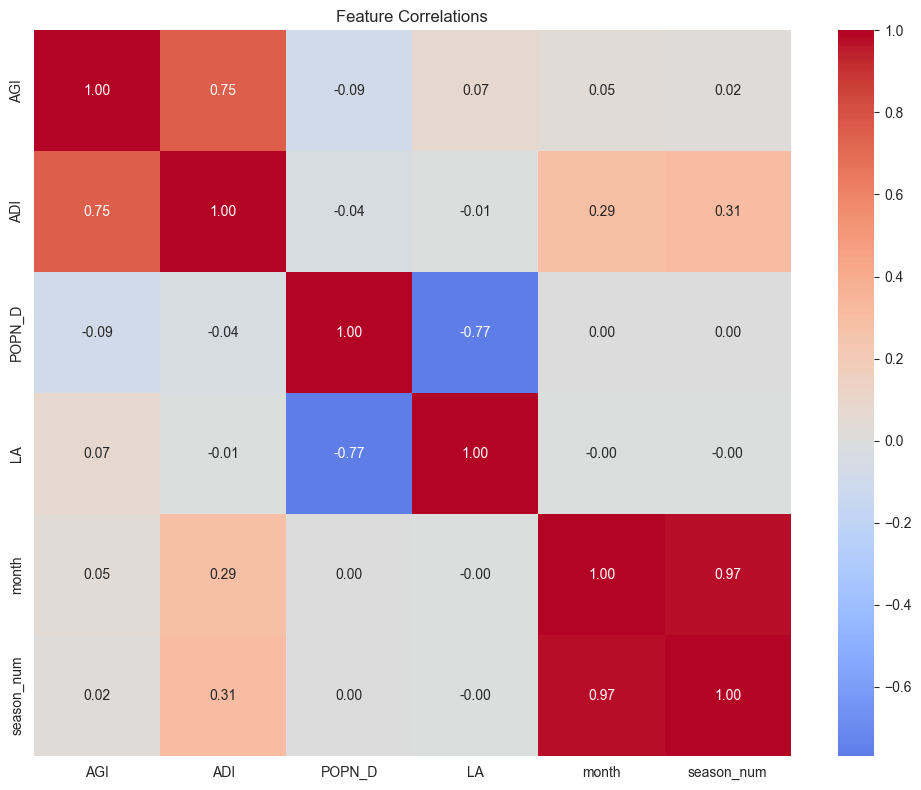

In [20]:
# 9. 特征相关性分析
def analyze_feature_correlations():
    # 获取所有数据
    all_data = model_loader.dataset.data.numpy()
    # 重塑数据为2D形式
    reshaped_data = all_data.reshape(-1, all_data.shape[-1])
    
    # 计算相关性矩阵
    corr_matrix = np.corrcoef(reshaped_data.T)
    
    # 可视化相关性矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                xticklabels=model_loader.feature_names,
                yticklabels=model_loader.feature_names,
                cmap='coolwarm', 
                center=0,
                annot=True,
                fmt='.2f')
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

analyze_feature_correlations()

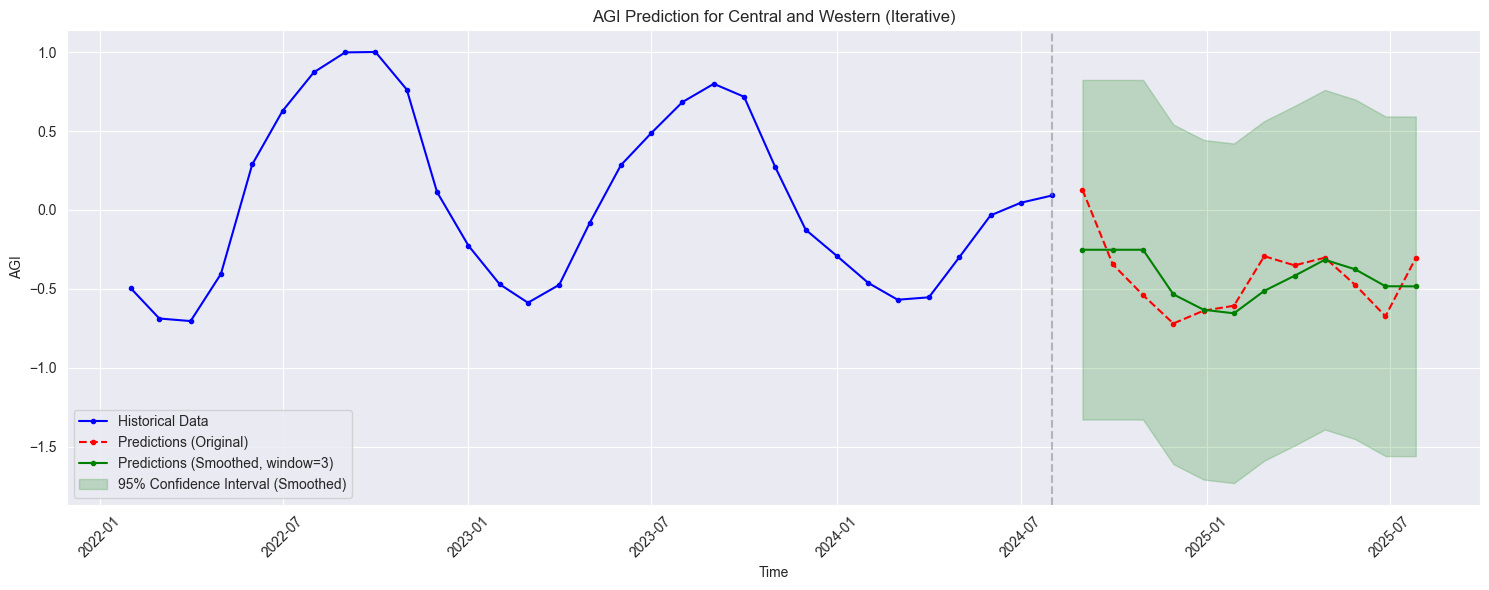


预测结果概要：
时间: 2024-08
预测值: 0.02 ± 0.40
时间: 2024-09
预测值: -0.26 ± 0.29
时间: 2024-10
预测值: -0.49 ± 0.25
时间: 2024-11
预测值: -0.53 ± 0.23
时间: 2024-12
预测值: -0.51 ± 0.41
时间: 2025-01
预测值: -0.40 ± 0.47
时间: 2025-02
预测值: -0.35 ± 0.52
时间: 2025-03
预测值: -0.31 ± 0.57
时间: 2025-04
预测值: -0.32 ± 0.43
时间: 2025-05
预测值: -0.35 ± 0.49
时间: 2025-06
预测值: -0.34 ± 0.43
时间: 2025-07
预测值: -0.33 ± 0.49


In [26]:
# 2. 时间序列预测分析 - 逐步预测实现

import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class TimeSeriesPredictor:
    def __init__(self, model_loader):
        self.model_loader = model_loader
        self.scaler = MinMaxScaler()
        
    def prepare_prediction_data(self, district_name, feature_index=0):
        """准备指定地区的预测数据"""
        district_indices = np.where(self.model_loader.district_labels == district_name)[0]
        
        if len(district_indices) == 0:
            raise ValueError(f"No data found for district: {district_name}")
            
        # 收集时间序列数据
        times = []
        values = []
        for idx in district_indices:
            data = self.model_loader.dataset[idx].numpy()
            times.append(pd.to_datetime(self.model_loader.time_labels[idx]))
            values.append(data[:, feature_index].mean())
            
        # 确保时间顺序
        time_series = pd.DataFrame({
            'time': times,
            'value': values
        }).sort_values('time')
        
        return time_series
        
    def predict_next_step(self, current_sequence, feature_index):
        """
        使用模型预测下一个时间步的值
        current_sequence: [1, time_window, input_dim]
        feature_index: 目标特征的索引
        """
        with torch.no_grad():
            recon, mu, log_var = self.model_loader.model(current_sequence)
            # 只获取最后一个时间步的预测
            next_pred = recon[:, -1:, :]  # [1, 1, input_dim]
            # 选择目标特征
            next_value = next_pred[:, :, feature_index]  # [1, 1]
        return next_value.squeeze().cpu().numpy()  # 返回标量
    
    def predict_next_steps_iterative(self, district_name, steps=6, feature_name='AGI'):
        """逐步预测未来几个时间步的值"""
        # 获取特征索引
        feature_index = self.model_loader.feature_names.index(feature_name)
        
        # 准备数据
        time_series = self.prepare_prediction_data(district_name, feature_index)
        
        # 获取最后一个完整序列
        district_indices = np.where(self.model_loader.district_labels == district_name)[0]
        last_idx = district_indices[-1]
        last_sequence = self.model_loader.dataset[last_idx].unsqueeze(0).to(self.model_loader.device)  # [1, time_window, input_dim]
        
        # 初始化预测列表
        predictions = []
        current_sequence = last_sequence.clone()
        
        for _ in range(steps):
            # 预测下一个时间步
            next_val = self.predict_next_step(current_sequence, feature_index)  # 标量
            
            # 创建新的预测点，保持其他特征不变或使用历史平均值
            input_dim = current_sequence.shape[2]
            new_pred = np.zeros(input_dim)
            new_pred[feature_index] = next_val
            new_pred = torch.FloatTensor(new_pred).unsqueeze(0).unsqueeze(0).to(self.model_loader.device)  # [1,1,input_dim]
            
            # 更新当前序列
            current_sequence = torch.cat([
                current_sequence[:, 1:, :],  # 移除最早的时间步
                new_pred  # 添加新的预测时间步
            ], dim=1)  # [1, time_window, input_dim]
            
            # 保存预测值
            predictions.append(next_val)
        
        # 生成未来时间点
        last_time = time_series['time'].iloc[-1]
        future_times = [last_time + timedelta(days=30*(i+1)) for i in range(steps)]
        
        return future_times, predictions
    
    def plot_predictions_iterative(self, district_name, feature_name='AGI', steps=6, window_size=3):
        """可视化历史数据和逐步预测结果，并进行平滑处理"""
        feature_index = self.model_loader.feature_names.index(feature_name)
        
        # 获取历史数据
        historical_data = self.prepare_prediction_data(district_name, feature_index)
        
        # 获取预测
        future_times, predictions = self.predict_next_steps_iterative(
            district_name, steps, feature_name
        )
        
        # 应用移动平均平滑
        if len(predictions) >= window_size:
            smoothed_predictions = np.convolve(predictions, np.ones(window_size)/window_size, mode='valid')
            # 为保持与时间点对齐，前面填充
            smoothed_predictions = np.pad(smoothed_predictions, (window_size-1,0), 'edge')
        else:
            smoothed_predictions = predictions
        
        # 创建图形
        plt.figure(figsize=(15, 6))
        
        # 绘制历史数据
        plt.plot(historical_data['time'], historical_data['value'], 
                'b.-', label='Historical Data')
        
        # 绘制预测（原始）
        plt.plot(future_times, predictions, 
                'r.--', label='Predictions (Original)')
        
        # 绘制预测（平滑）
        plt.plot(future_times, smoothed_predictions, 
                'g.-', label=f'Predictions (Smoothed, window={window_size})')
        
        # 添加置信区间（使用平滑后的标准差）
        pred_std = historical_data['value'].std()
        plt.fill_between(future_times,
                        smoothed_predictions - 1.96*pred_std,
                        smoothed_predictions + 1.96*pred_std,
                        color='g', alpha=0.2,
                        label='95% Confidence Interval (Smoothed)')
        
        plt.title(f'{feature_name} Prediction for {district_name} (Iterative)')
        plt.xlabel('Time')
        plt.ylabel(feature_name)
        plt.legend()
        plt.grid(True)
        
        # 添加垂直线分隔历史数据和预测
        plt.axvline(x=historical_data['time'].iloc[-1], 
                   color='gray', linestyle='--', alpha=0.5)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return historical_data, future_times, predictions, smoothed_predictions
    
    def analyze_prediction_uncertainty_iterative(self, district_name, feature_name='AGI', 
                                    steps=6, n_samples=100):
        """通过多次采样分析预测的不确定性（逐步预测）"""
        feature_index = self.model_loader.feature_names.index(feature_name)
        all_predictions = []
        
        for _ in range(n_samples):
            _, predictions = self.predict_next_steps_iterative(
                district_name, steps, feature_name
            )
            all_predictions.append(predictions)
            
        all_predictions = np.array(all_predictions)
        
        # 计算统计量
        mean_predictions = np.mean(all_predictions, axis=0)
        std_predictions = np.std(all_predictions, axis=0)
        
        return mean_predictions, std_predictions

# 使用示例
predictor = TimeSeriesPredictor(model_loader)

# 预测并可视化单个地区的趋势（逐步预测）
district_name = "Central and Western"  # 替换为实际的地区名
historical, future_times, predictions,smooth_predictions = predictor.plot_predictions_iterative(
    district_name, feature_name='AGI', steps=12
)

# 分析预测的不确定性
mean_pred, std_pred = predictor.analyze_prediction_uncertainty_iterative(
    district_name, feature_name='AGI', steps=12, n_samples=100
)

# 打印预测结果
print("\n预测结果概要：")
for time, pred, std in zip(future_times, mean_pred, std_pred):
    print(f"时间: {time.strftime('%Y-%m')}")
    print(f"预测值: {pred:.2f} ± {2*std:.2f}")

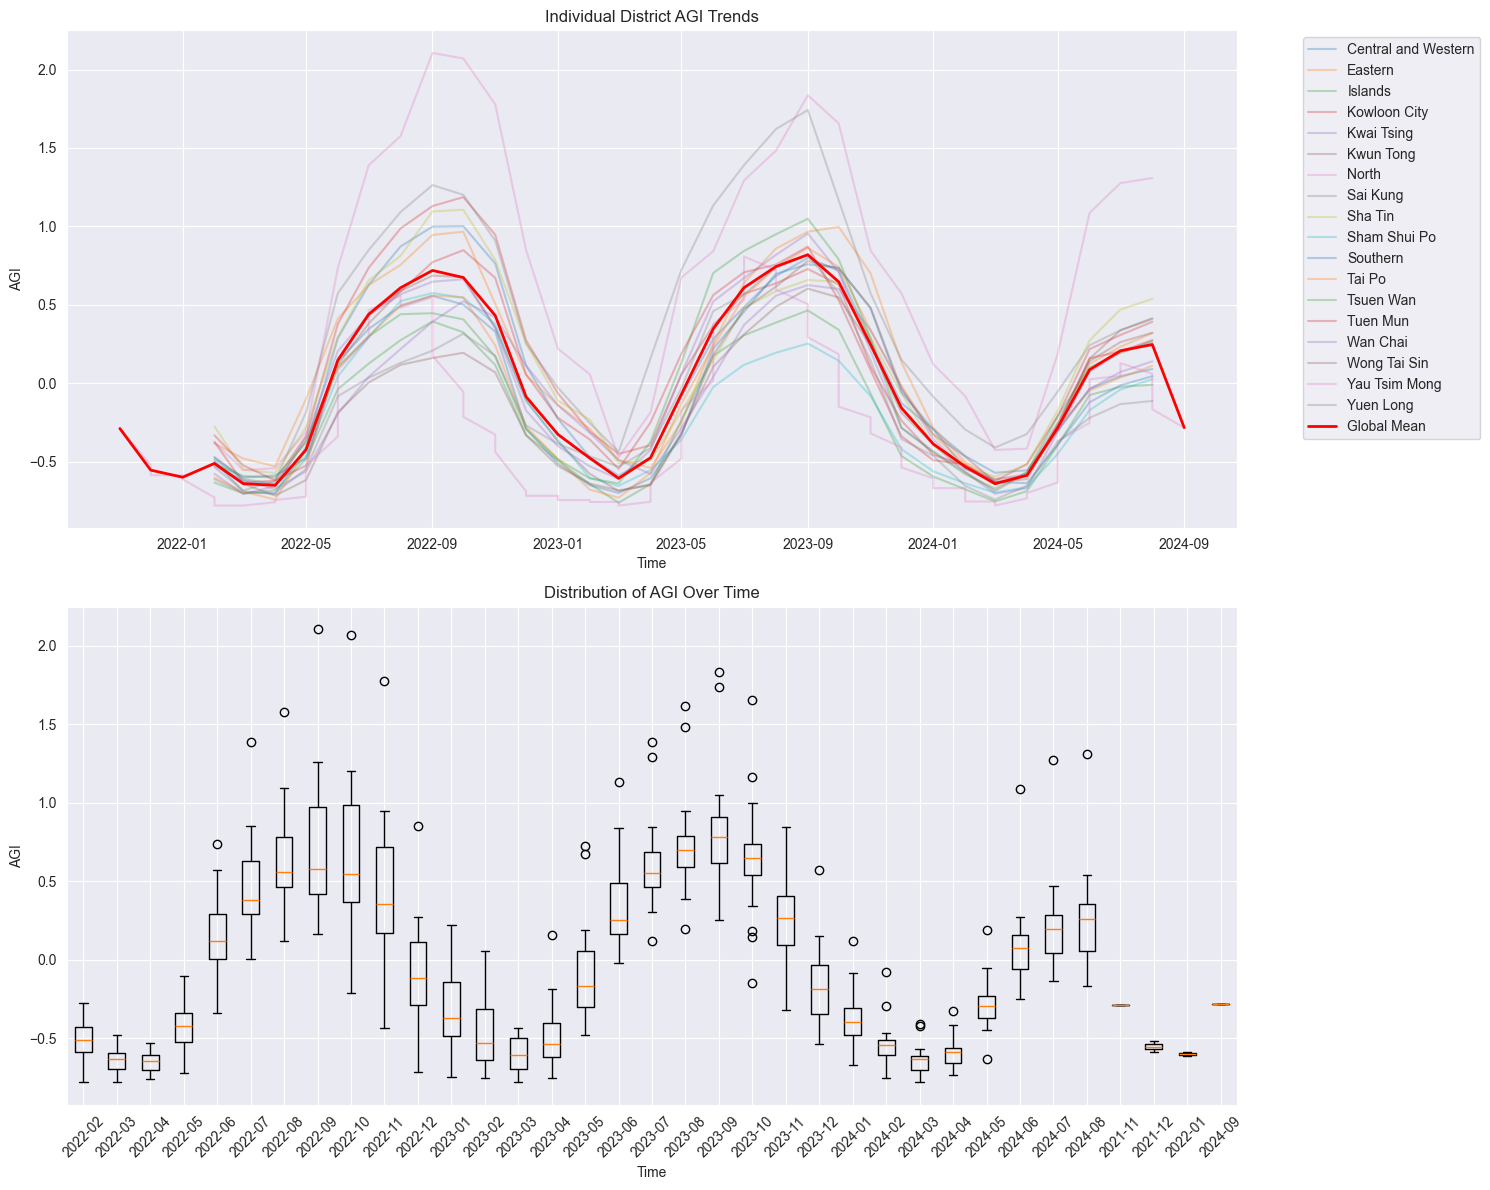

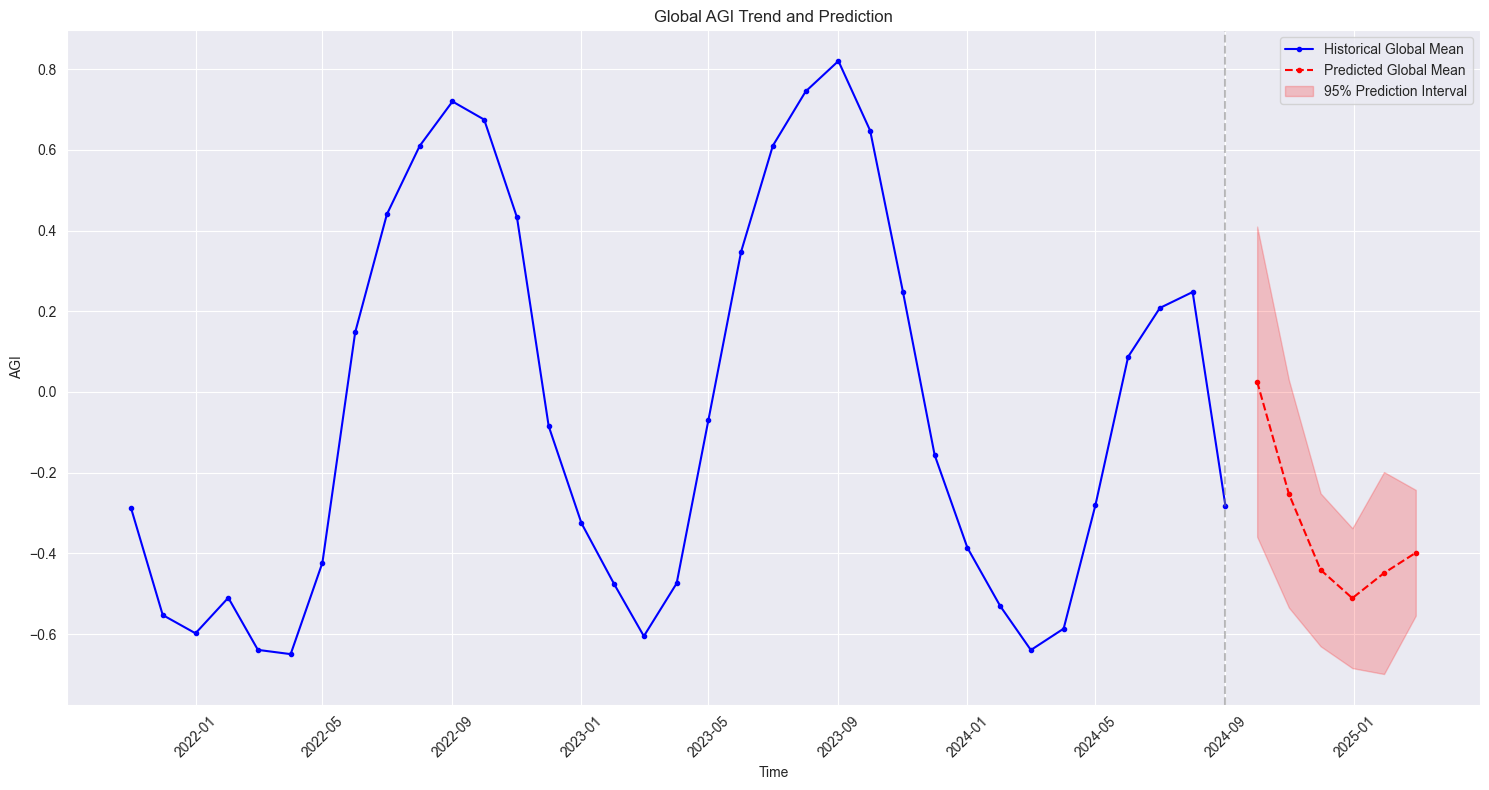

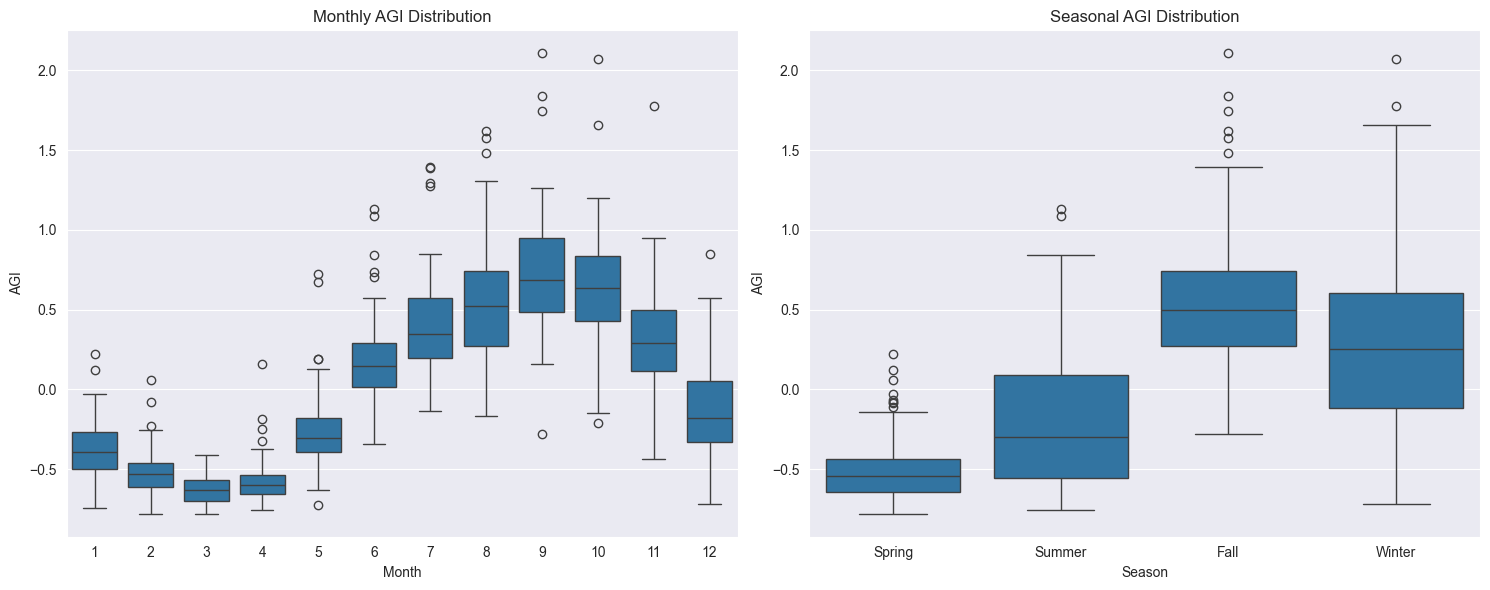


=== AGI 趋势分析报告 ===

总体统计:
平均值: -0.00
标准差: 0.57
趋势斜率: 0.01


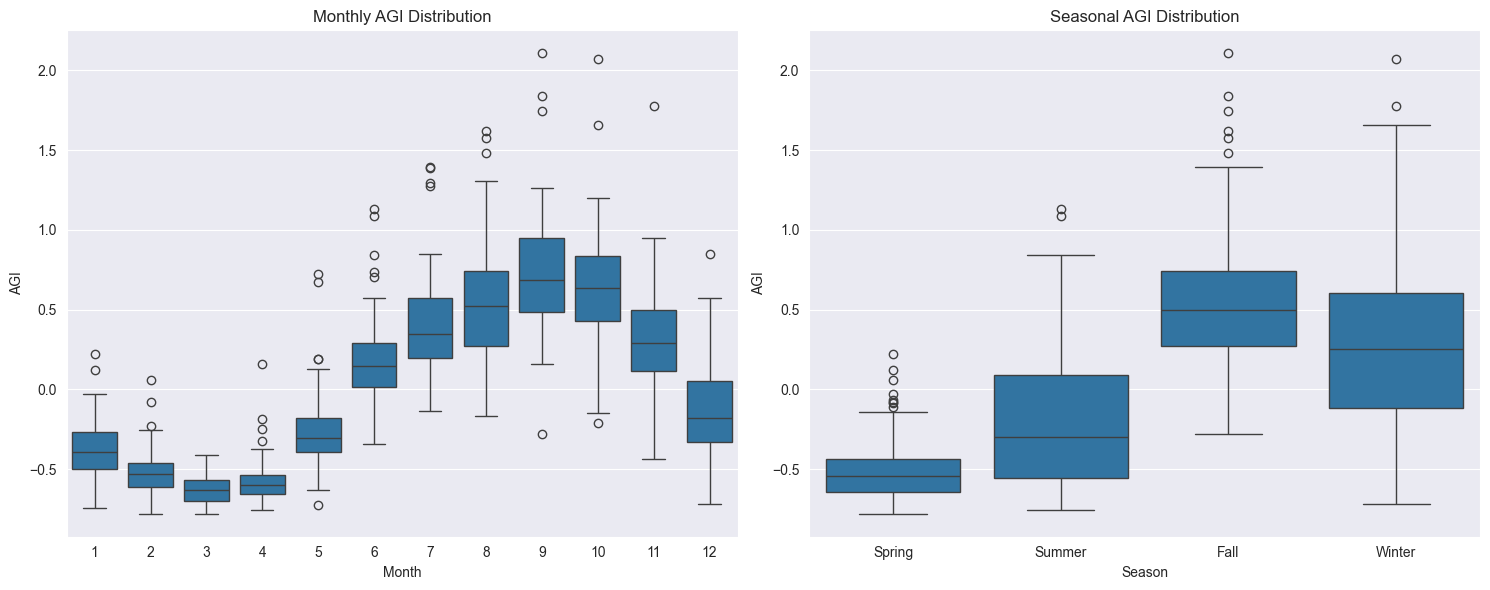


季节性统计:
            mean       std
season                    
Spring -0.514850  0.189849
Summer -0.211218  0.400374
Fall    0.544518  0.413265
Winter  0.274307  0.516885

全局预测结果：
时间: 2024-10
预测值: 0.03 ± 0.38
时间: 2024-10
预测值: -0.25 ± 0.28
时间: 2024-11
预测值: -0.44 ± 0.19
时间: 2024-12
预测值: -0.51 ± 0.17
时间: 2025-01
预测值: -0.45 ± 0.25
时间: 2025-02
预测值: -0.40 ± 0.16


In [25]:
# 11. 总体趋势分析和预测 - 修改版

import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class GlobalTrendAnalyzer:
    def __init__(self, model_loader):
        self.model_loader = model_loader
            
    def collect_global_data(self, feature_name='AGI'):
        """收集所有地区的数据并计算总体趋势"""
        feature_index = self.model_loader.feature_names.index(feature_name)
        
        # 创建时间序列数据框
        all_data = []
        for idx in range(len(self.model_loader.dataset)):
            data = self.model_loader.dataset[idx].numpy()
            time = pd.to_datetime(self.model_loader.time_labels[idx])
            district = self.model_loader.district_labels[idx]
            value = data[:, feature_index].mean()
            
            all_data.append({
                'time': time,
                'district': district,
                'value': value
            })
        
        df = pd.DataFrame(all_data)
        return df
        
    def analyze_global_trends(self, feature_name='AGI'):
        """分析和可视化总体趋势"""
        df = self.collect_global_data(feature_name)
        
        # 计算全局平均趋势
        global_trend = df.groupby('time', observed=False)['value'].agg(['mean', 'std']).reset_index()
        
        # 创建图形
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # 1. 所有地区的时间序列
        for district in df['district'].unique():
            district_data = df[df['district'] == district]
            ax1.plot(district_data['time'], district_data['value'], 
                    alpha=0.3, label=district)
                
        # 添加全局平均线
        ax1.plot(global_trend['time'], global_trend['mean'], 
                'r-', linewidth=2, label='Global Mean')
        
        ax1.set_title(f'Individual District {feature_name} Trends')
        ax1.set_xlabel('Time')
        ax1.set_ylabel(feature_name)
        ax1.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. 箱型图显示分布变化
        ax2.boxplot([df[df['time'] == time]['value'] 
                    for time in df['time'].unique()],
                   tick_labels=[t.strftime('%Y-%m') for t in df['time'].unique()])
        
        ax2.set_title(f'Distribution of {feature_name} Over Time')
        ax2.set_xlabel('Time')
        ax2.set_ylabel(feature_name)
        ax2.grid(True)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return global_trend
        
    def predict_global_trend(self, feature_name='AGI', steps=6, n_samples=100):
        """预测总体趋势"""
        predictor = TimeSeriesPredictor(self.model_loader)
        
        # 收集所有地区的预测
        all_predictions = []
        districts = np.unique(self.model_loader.district_labels)
        
        # 禁用matplotlib的交互式显示
        plt.ioff()
        
        for district in districts:
            try:
                mean_pred, std_pred = predictor.analyze_prediction_uncertainty_iterative(
                    district, feature_name, steps, n_samples=20  # 使用逐步预测方法
                )
                all_predictions.append(mean_pred)
            except ValueError as e:
                print(e)
                continue
        
        # 重新启用matplotlib的交互式显示
        plt.ion()
                
        all_predictions = np.array(all_predictions)
        
        # 计算全局预测统计量
        global_mean = np.mean(all_predictions, axis=0)
        global_std = np.std(all_predictions, axis=0)
        
        # 获取历史数据
        historical_data = self.collect_global_data(feature_name)
        global_historical = historical_data.groupby('time', observed=False)['value'].mean()
        
        # 生成未来时间点
        last_time = historical_data['time'].max()
        future_times = [last_time + timedelta(days=30*(i+1)) for i in range(steps)]
        
        # 可视化
        plt.figure(figsize=(15, 8))
        
        # 绘制历史趋势
        plt.plot(global_historical.index, global_historical.values,
                'b.-', label='Historical Global Mean')
        
        # 绘制预测趋势
        plt.plot(future_times, global_mean, 
                'r.--', label='Predicted Global Mean')
        
        # 添加预测区间
        plt.fill_between(future_times,
                        global_mean - 2*global_std,
                        global_mean + 2*global_std,
                        color='r', alpha=0.2,
                        label='95% Prediction Interval')
        
        plt.title(f'Global {feature_name} Trend and Prediction')
        plt.xlabel('Time')
        plt.ylabel(feature_name)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        
        # 添加垂直线分隔历史数据和预测
        plt.axvline(x=last_time, color='gray', 
                   linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        return global_historical, future_times, global_mean, global_std
        
    def analyze_seasonal_patterns(self, feature_name='AGI'):
        """分析季节性模式"""
        df = self.collect_global_data(feature_name)
        df['month'] = df['time'].dt.month
        df['season'] = pd.cut(df['month'], 
                            bins=[0,3,6,9,12], 
                            labels=['Spring','Summer','Fall','Winter'])
        
        # 创建图形
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 1. 月度箱型图
        sns.boxplot(data=df, x='month', y='value', ax=ax1)
        ax1.set_title(f'Monthly {feature_name} Distribution')
        ax1.set_xlabel('Month')
        ax1.set_ylabel(feature_name)
        
        # 2. 季节性箱型图
        sns.boxplot(data=df, x='season', y='value', ax=ax2)
        ax2.set_title(f'Seasonal {feature_name} Distribution')
        ax2.set_xlabel('Season')
        ax2.set_ylabel(feature_name)
        
        plt.tight_layout()
        plt.show()
        
        # 计算季节性统计量
        seasonal_stats = df.groupby('season', observed=False)['value'].agg(['mean', 'std'])
        return seasonal_stats
        
    def generate_trend_report(self, feature_name='AGI'):
        """生成趋势分析报告"""
        # 收集数据
        df = self.collect_global_data(feature_name)
        global_trend = df.groupby('time')['value'].agg(['mean', 'std'])
        
        # 计算关键指标
        overall_mean = df['value'].mean()
        overall_std = df['value'].std()
        trend_slope = np.polyfit(range(len(global_trend)), global_trend['mean'], 1)[0]
        
        # 打印报告
        print(f"\n=== {feature_name} 趋势分析报告 ===")
        print(f"\n总体统计:")
        print(f"平均值: {overall_mean:.2f}")
        print(f"标准差: {overall_std:.2f}")
        print(f"趋势斜率: {trend_slope:.2f}")
        
        # 季节性分析
        seasonal_stats = self.analyze_seasonal_patterns(feature_name)
        print("\n季节性统计:")
        print(seasonal_stats)
        
        return {
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'trend_slope': trend_slope,
            'seasonal_stats': seasonal_stats
        }

# 使用示例
analyzer = GlobalTrendAnalyzer(model_loader)

# 1. 分析历史趋势
global_trend = analyzer.analyze_global_trends(feature_name='AGI')

# 2. 预测总体趋势
historical, future_times, global_mean, global_std = analyzer.predict_global_trend(
    feature_name='AGI', steps=6, n_samples=100
)

# 3. 分析季节性模式
seasonal_stats = analyzer.analyze_seasonal_patterns(feature_name='AGI')

# 4. 生成趋势报告
trend_report = analyzer.generate_trend_report(feature_name='AGI')

# 打印预测结果
print("\n全局预测结果：")
for time, mean, std in zip(future_times, global_mean, global_std):
    print(f"时间: {time.strftime('%Y-%m')}")
    print(f"预测值: {mean:.2f} ± {2*std:.2f}")